# A Model and Dataset for NBA Wingspan and Standing Reach Measurements

![](siora-photography-cixohzDpNIo-unsplash.jpg)
<span>Photo by <a href="https://unsplash.com/@siora18?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Siora Photography</a> on <a href="https://unsplash.com/s/photos/measurements?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Just would like to see the top players in the combine, so we know their measurements and stuff. No big deal.</p>&mdash; Evan Zamir (@thecity2) <a href="https://twitter.com/thecity2/status/598197375358750721?ref_src=twsrc%5Etfw">May 12, 2015</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Did anyone ever end up publishing corrected standing reach measurements? Is Chriss’ standing reach really only 8’9”?</p>&mdash; Evan Zamir (@thecity2) <a href="https://twitter.com/thecity2/status/745662479032737792?ref_src=twsrc%5Etfw">June 22, 2016</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">I don&#39;t know if people realize Mo Wagner attended the Combine last year and has measurements up on the NBA website. Last year measured at 6&#39;11&quot; with 9&#39; reach and 7&#39; wingspan.</p>&mdash; Evan Zamir (@thecity2) <a href="https://twitter.com/thecity2/status/996862410555146241?ref_src=twsrc%5Etfw">May 16, 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Just realized Mikal Bridges didn&#39;t participate in the measurements. 🤨</p>&mdash; Evan Zamir (@thecity2) <a href="https://twitter.com/thecity2/status/997226701842100224?ref_src=twsrc%5Etfw">May 17, 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Screw mandatory drug testing. I&#39;d implement mandatory standing reach and wingspan measurements before each season.</p>&mdash; Evan Zamir (@thecity2) <a href="https://twitter.com/thecity2/status/598201697375096832?ref_src=twsrc%5Etfw">May 12, 2015</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Seems like very few wings in this draft stand out from a measurements perspective. I think Klay is longer than most of them.</p>&mdash; Evan Zamir (@thecity2) <a href="https://twitter.com/thecity2/status/337080909285187584?ref_src=twsrc%5Etfw">May 22, 2013</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

The above are only a small sample of the times I have tweeted on player's measurements. It's kind of a big deal (no pun), and oftentimes, draft followers such as myself are left yearning for the measurements of players that skip the annual NBA Draft Combine. Over the years, I've thought about collecting enough data to put together my own measurements model to help with this, and I finally decided to do it. I should say my first attempt at modeling this was to go the Bayesian route using Pyro once again, and I do share that in this article. But it turns out simply using scikit-learn ElasticNet is a better predictor, so unless you're super into inference and distributions and stuff, the TL;DR will be the first part of this post. I encourage my more dedicated readers to take the dataset I've provided and go wild with your own models. I think in the long run the most significant contribution of this post will actually be the dataset I've collected.

As always...import the packages.

In [801]:
from io import BytesIO

import bz2
import json
import os
import warnings
import itertools
import random

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
torch.set_default_dtype(torch.float64)
from IPython import display
import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.autoguide import AutoMultivariateNormal, AutoDiagonalNormal, init_to_mean

from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.5.1')
assert torch.__version__=='1.7.1'
%matplotlib inline
warnings.simplefilter('ignore')
from py_ball import draft

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

I used the [py_ball package](https://github.com/basketballrelativity/py_ball) to collect the data from every available NBA Combine from the NBA's stats website. The dataset is in the github repo already, but if you want to reproduce it yourself, just uncomment the code below.

In [802]:
# draft_records = draft.Draft(headers=HEADERS,
#                          endpoint='draftcombinestats',
#                          league_id='00',
#                          season_year='All Time').data['DraftCombineStats']
# draft_df = pd.DataFrame.from_records(draft_records)
# draft_df['NORMALIZED_PLAYER_NAME'] = draft_df['PLAYER_NAME'].map(lambda name: "-".join(name.lower().replace('.','').replace("'",'').split(' ')))
# draft_df['WEIGHT'].replace('', np.nan, inplace=True)
# draft_df['WEIGHT'] = draft_df['WEIGHT'].astype(float)
# draft_df['HEIGHT_WO_SHOES'].replace('', np.nan, inplace=True)
# draft_df = draft_df.dropna(subset=['WEIGHT','HEIGHT_WO_SHOES','WINGSPAN','STANDING_REACH'],)
# draft_df.to_csv('data/historical_draft_data.csv')
pd.read_csv('data/historical_draft_data.csv')
draft_df.head()

,SEASON,PLAYER_ID,FIRST_NAME,LAST_NAME,PLAYER_NAME,POSITION,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,THREE_QUARTER_SPRINT,BENCH_PRESS,NORMALIZED_PLAYER_NAME
0,2002,2403,Nene,,Nene,PF,81.25,6' 9.25'',NaN,None,253.0,88.50,7' 4.5'',109.0,9' 1'',NaN,NaN,NaN,30.0,34.0,10.73,NaN,3.19,16.0,nene-
1,2007,12204,Mohamed,Abukar,Mohamed Abukar,SF,80.00,6' 8'',81.75,6' 9.75'',210.0,81.00,6' 9'',103.0,8' 7'',8.9,NaN,NaN,30.5,35.0,11.78,NaN,3.37,15.0,mohamed-abukar
2,2020,1630173,Precious,Achiuwa,Precious Achiuwa,PF,79.50,6'7.50'',80.70,6'8.75'',234.0,84.75,7'0.75'',108.5,9'0.50'',6.7,9.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,precious-achiuwa
3,2005,101165,Alex,Acker,Alex Acker,SG,75.75,6' 3.75'',76.75,6' 4.75'',183.0,84.00,7' 0'',102.5,8' 6.5'',NaN,NaN,NaN,28.0,32.0,11.67,NaN,3.35,11.0,alex-acker
4,2012,203112,Quincy,Acy,Quincy Acy,PF,78.50,6' 6.5'',79.75,6' 7.75'',223.8,86.75,7' 2.75'',106.5,8' 10.5'',7.1,9.5,11.0,32.0,37.0,10.48,NaN,3.28,13.0,quincy-acy


I used my personal NCAA scraper (which I use for *shameless plug* my daily [Top Lines! newsletter](https://toplines.mailchimpsites.com/)) to collect player stats going back to the 2004-05 season where there was substantial enough play-by-play to collect dunks. In the `ncaa-historical.csv` dataset I've included data on dunks, steals, blocks, offensive and defensive rebounding. Dunks and steals are per 100 possessions. Rebounding is a % of total rebounding opportunities (typicall referred to as ORB% and DRB%, respectively). Blocks are defined as the percent of opponent 2-point field goal attempts (BLK%) in the same way as calculated at [Basketball-Reference](http://www.basketball-reference.com).

In [803]:
ncaa_stats = pd.read_csv('data/ncaa-historical.csv')
print(ncaa_stats.head())
draft_df['SEASON'] = draft_df['SEASON'].astype('int64')
merged = pd.merge(left=draft_df,right=ncaa_stats,left_on=['NORMALIZED_PLAYER_NAME','SEASON'],
        right_on=['name','season'])
merged.to_csv('data/ncaa-merged.csv')

   season          name   pid            team   g  min  dunks  poss   stl  \
0    2006    adam-boone   168       Minnesota  22  794   0.00  1317  2.43   
1    2007  jay-mitchell  1015      Texas Tech   7   41   1.44    69  1.44   
2    2009  jay-mitchell  1015  Kennesaw State   4   36   0.00    58  1.72   
3    2006  andrew-meloy  1850    Oral Roberts   2   16   0.00    28  0.00   
4    2010     joe-clark  2540            Army   1    1   0.00     1  0.00   

    blk     orb    drb  
0  1.55    1.60   9.68  
1  2.85    7.04  27.87  
2  3.37   13.17  17.78  
3  0.00    0.00  27.78  
4  0.00  133.33   0.00  


I then join the Combine and Historical datasets. The joining is done on name and season and there are a small number of cases where there are two players with the same name in the same draft season, which means there are a few duplicated rows that enter into the regression. If you want to eek out a teensy weensy more predictive power, go ahead and clean out those rows yo damn self. For the purposes here, I can virtually guarantee it won't make a significant difference.

In [804]:
train_df, test_df = train_test_split(merged,test_size=0.15)
print(f"{len(train_df)} players in training set. {len(test_df)} players in test set")
train_df.head()

698 players in training set. 124 players in test set


,SEASON,PLAYER_ID,FIRST_NAME,LAST_NAME,PLAYER_NAME,POSITION,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,THREE_QUARTER_SPRINT,BENCH_PRESS,NORMALIZED_PLAYER_NAME,season,name,pid,team,g,min,dunks,poss,stl,blk,orb,drb
798,2016,1627787,Kyle,Wiltjer,Kyle Wiltjer,PF,80.75,6' 8.75'',82.00,6' 10'',242.8,84.25,7' 0.25'',102.5,8' 6.5'',15.25,8.25,9.50,28.5,35.5,11.35,3.04,3.48,NaN,kyle-wiltjer,2016,kyle-wiltjer,56355,Gonzaga,30,1006,0.00,1724,0.64,2.48,6.63,15.57
90,2017,1628515,Isaiah,Briscoe,Isaiah Briscoe,PG,73.25,6' 1.25'',74.75,6' 2.75'',222.4,81.00,6' 9'',99.5,8' 3.5'',11.00,9.00,9.25,28.0,33.5,10.95,2.85,3.38,11.0,isaiah-briscoe,2017,isaiah-briscoe,3936294,Kentucky,26,764,0.07,1421,1.34,0.64,5.82,14.89
372,2008,12257,Davon,Jefferson,Davon Jefferson,SF,77.25,6' 5.25'',78.50,6' 6.5'',213.0,81.50,6' 9.5'',105.0,8' 9'',12.00,NaN,NaN,27.0,32.0,12.02,NaN,3.36,2.0,davon-jefferson,2008,davon-jefferson,36055,USC,20,560,3.12,898,2.00,4.03,11.79,17.29
346,2006,200812,Daniel,Horton,Daniel Horton,PG-SG,72.50,6' 0.5'',74.25,6' 2.25'',198.0,79.00,6' 7'',96.5,8' 0.5'',8.00,NaN,NaN,30.0,36.5,10.35,NaN,3.16,17.0,daniel-horton,2006,daniel-horton,11113,Michigan,20,685,0.00,1140,3.51,1.10,1.44,7.93
727,2018,1629019,Allonzo,Trier,Allonzo Trier,SG,75.75,6' 3.75'',77.25,6' 5.25'',198.0,78.75,6' 6.75'',98.0,8' 2'',4.95,8.25,10.50,32.0,40.0,11.02,2.97,3.14,11.0,allonzo-trier,2018,allonzo-trier,3907525,Arizona,32,1093,0.69,1896,1.11,1.07,1.46,9.85


As you can see above there are nearly 700 players in the training set, which is substantial. We're going to add to our historical stats the player's height (barefoot) and weight, which are essentially always available in some sense. I should point out that there are many other fields here, such as vertical, that could be used either as features or targets. For example, one could add vert as a feature and then for players that skip the combine, you could create predictions for those players over a range of verts you expect are fairly realistic to simulate how the wingspan and standing reach would be affected. Especially for vert, which is essentially a reflection of the latent variable *athleticism*, the interactions it would create (in a model sense) with the other features could be really useful. Same goes for the other athletic testing results. Perhaps, in a future post I will explore such complexifications (whew).

In [805]:
x_train = train_df[['HEIGHT_WO_SHOES','WEIGHT','stl','blk','orb','drb','dunks']].to_numpy()
y_train = train_df[['WINGSPAN','STANDING_REACH']].to_numpy()
x_test = torch.from_numpy(test_df[['HEIGHT_WO_SHOES','WEIGHT','stl','blk','orb','drb','dunks']].to_numpy())
y_test = torch.from_numpy(test_df[['WINGSPAN','STANDING_REACH']].to_numpy())
print(x_train[:5,:],'\n',y_train[:5,:])

[[8.075e+01 2.428e+02 6.400e-01 2.480e+00 6.630e+00 1.557e+01 0.000e+00]
 [7.325e+01 2.224e+02 1.340e+00 6.400e-01 5.820e+00 1.489e+01 7.000e-02]
 [7.725e+01 2.130e+02 2.000e+00 4.030e+00 1.179e+01 1.729e+01 3.120e+00]
 [7.250e+01 1.980e+02 3.510e+00 1.100e+00 1.440e+00 7.930e+00 0.000e+00]
 [7.575e+01 1.980e+02 1.110e+00 1.070e+00 1.460e+00 9.850e+00 6.900e-01]] 
 [[ 84.25 102.5 ]
 [ 81.    99.5 ]
 [ 81.5  105.  ]
 [ 79.    96.5 ]
 [ 78.75  98.  ]]


In [815]:
skipped_combine = pd.read_csv('data/skipped_combine.csv')
prospects = pd.read_csv('data/prospects_2021.csv')
x_skipped = skipped_combine[['height','weight','stl','blk','orb','drb','dunks']].to_numpy()
x_prospects = prospects[['height','weight','stl','blk','orb','drb','dunks']].to_numpy()

It's fun to look at the joint distributions of all these stats. So look at them. NOW.

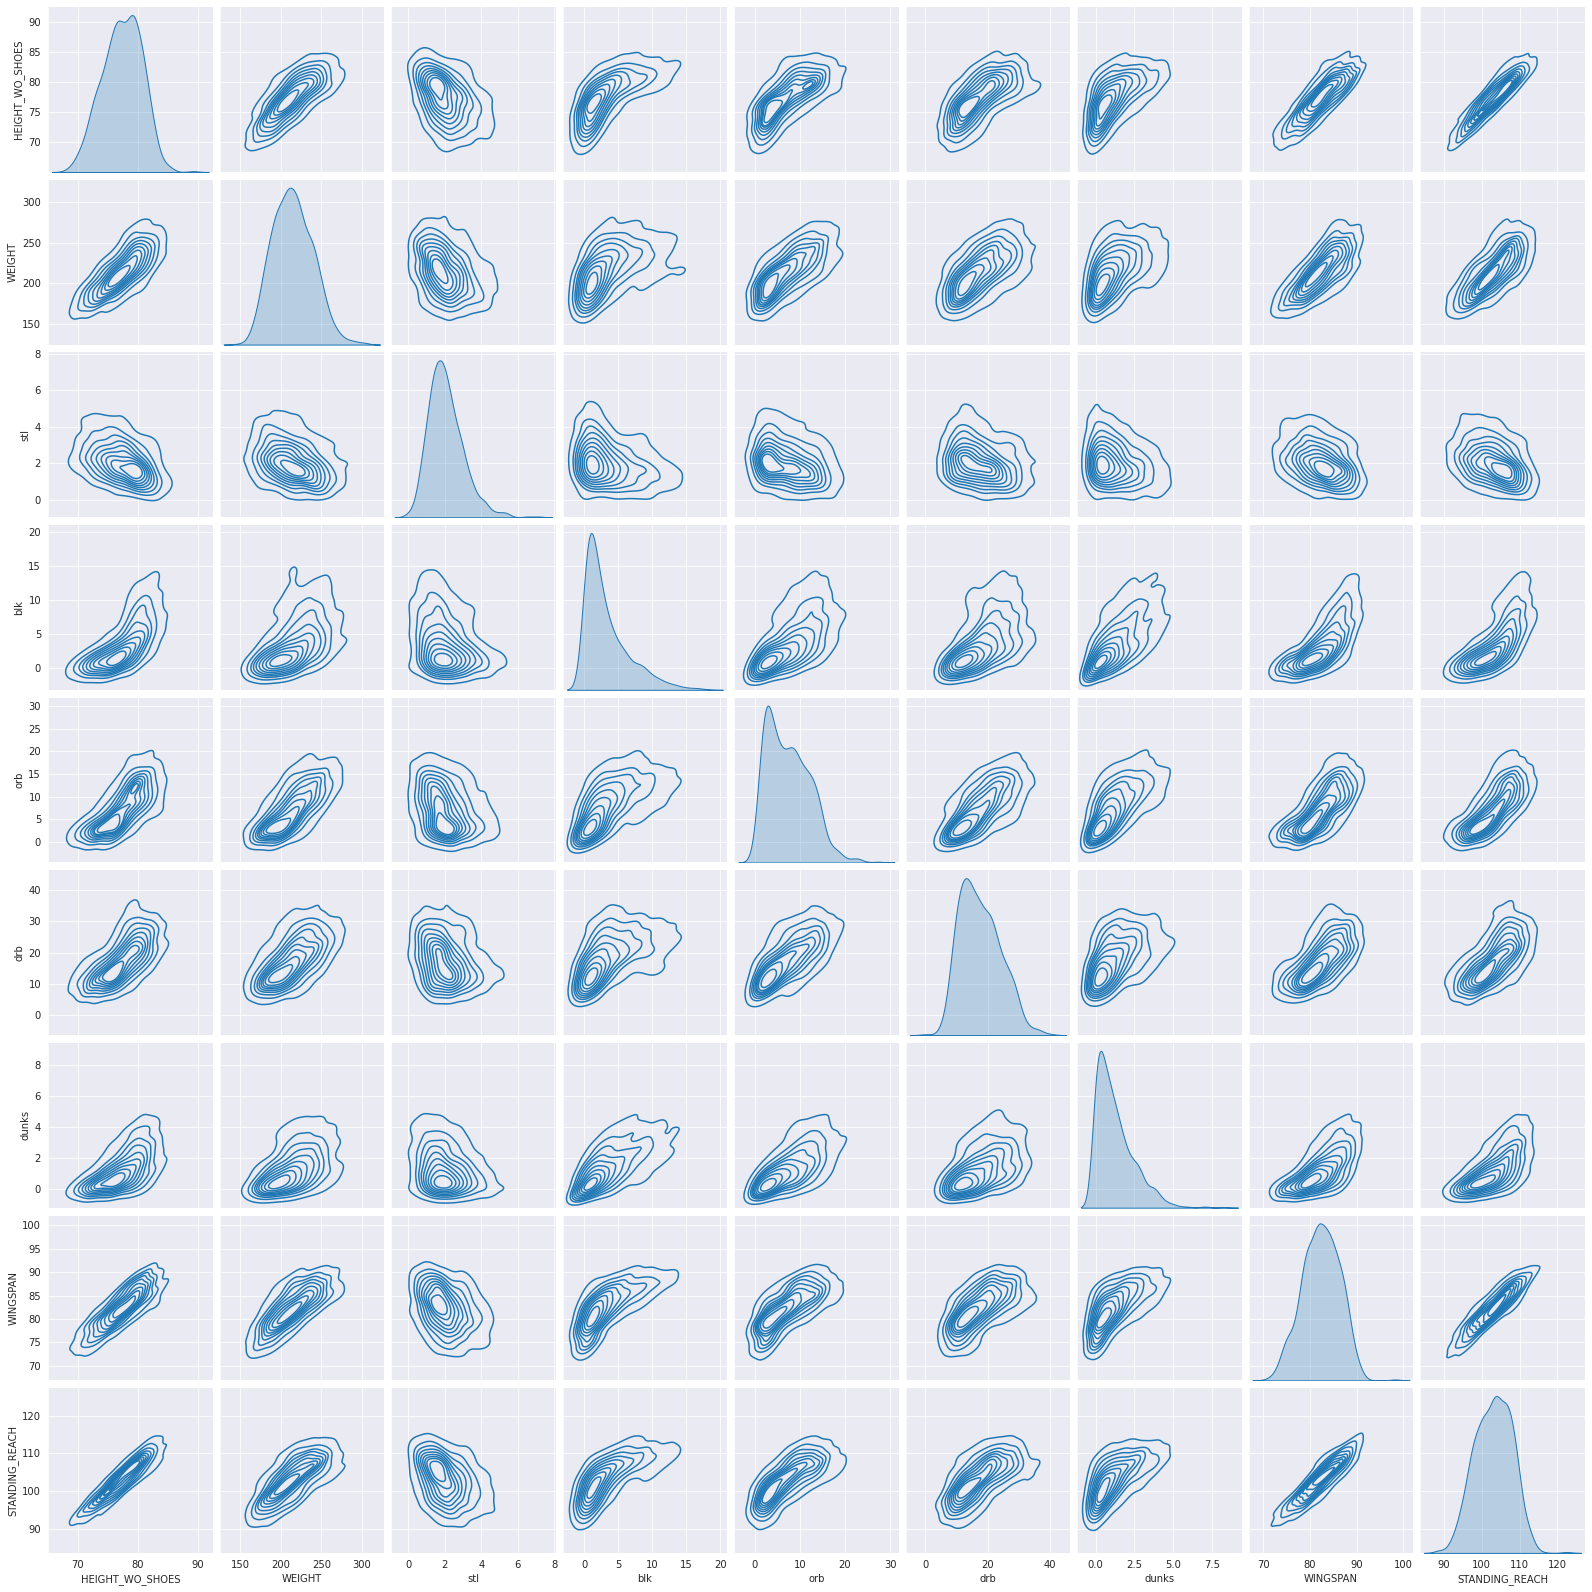

In [465]:
sns.pairplot(merged[['HEIGHT_WO_SHOES','WEIGHT','stl','blk','orb','drb','dunks','WINGSPAN','STANDING_REACH']],kind='kde')

## The Machine Learning Part

Ok, so this part is going to be fairly quick, but useful. First we standardize the features (this helps for some of the algorithms below).

In [826]:
std, mean = torch.std_mean(torch.tensor(x_train),axis=0)
std = std.numpy()
mean = mean.numpy()
x_train_norm = (x_train-mean)/std
x_test_norm = (x_test-mean)/std
x_skipped_norm = (x_skipped-mean)/std
x_prospects_norm = (x_prospects-mean)/std
x_train_norm.shape

(698, 7)

I tried several models from sklearn, tweaking the parameters manually or just using a grid search to do it for me. In the end even though the ElasticNet perhaps didn't have quite the very lowest loss, I'm still going to use that model for the rest of this section to show the results. The difference it makes in the predictions is going to be on the order of less than a tenth of an inch in any case. By the way, the loss showed below is the root mean square error combined for both wingspan and standing reach. This means that essentially most predictions will fall within 1-2 inches for both wingspan and standing reach, respectively. You can see that in the results that follow.

In [727]:
parameters = {'l1_ratio':[0.1,0.5,0.7,0.9,0.95,0.99,1.0],'alpha':[1e-4,1e-3,1e-2,0.1,0.2,0.5]}
mten = GridSearchCV(MultiTaskElasticNetCV(), parameters).fit(x_train_norm, y_train)
predictions_mten = mten.predict(x_test_norm)
loss = (torch.tensor(predictions_mten)-y_test).square().sum(axis=1).mean().sqrt()
loss

tensor(2.5862)

In [751]:
gpr = GaussianProcessRegressor()
gpr = GaussianProcessRegressor(kernel=Matern(nu=0.1)).fit(x_train_norm, y_train)
predictions_gpr = gpr.predict(x_test_norm)
loss = (torch.tensor(predictions_gpr)-y_test).square().sum(axis=1).mean().sqrt()
loss

tensor(2.6980)

In [784]:
mlp = MLPRegressor(solver='lbfgs',activation='relu',tol=1e-5).fit(x_train_norm, y_train)
predictions_mlp = mlp.predict(x_test_norm)
loss = (torch.tensor(predictions_mlp)-y_test).square().sum(axis=1).mean().sqrt()
loss

tensor(2.5793)

In [800]:
parameters = {'n_estimators':[50,100,200],'learning_rate':[0.1,0.01,0.001,0.2],'max_depth':[1,2,3],'loss':['ls','lad','huber'],'subsample':[0.1,0.2,0.5,1.0]}
gbr_ws = GridSearchCV(GradientBoostingRegressor(),parameters).fit(x_train_norm,y_train[:,0])
gbr_sr = GridSearchCV(GradientBoostingRegressor(),parameters).fit(x_train_norm,y_train[:,1])

predictions_gbr = np.zeros(y_test.shape)
predictions_gbr[:,0] = gbr_ws.predict(x_test_norm)
predictions_gbr[:,1] = gbr_sr.predict(x_test_norm)
loss = (torch.tensor(predictions_gbr)-y_test).square().sum(axis=1).mean().sqrt()
loss

tensor(2.5753)

Here is a random sample of predictions from the test set. The measurements with a bunch of significant digits (eg `array([ 79.56699585, 100.7449053 ])`) are the model predictions. The measurements underneath the`PLAYER_NAME` are from the Combine. Visual inspection shows that in most cases the model does a pretty good job. You should re-run this to see other samples, or just run it on the entire test set, if you're not satisfied with just a small peek.

In [806]:
random.sample(list(zip(test_df[['PLAYER_NAME','WINGSPAN','STANDING_REACH']].iterrows(),predictions_mten)),10)

[((363,
   PLAYER_NAME       Rick Jackson
   WINGSPAN                    86
   STANDING_REACH           106.5
   Name: 363, dtype: object),
  array([ 86.28277439, 107.8550966 ])),
 ((447,
   PLAYER_NAME       Malcolm Lee
   WINGSPAN                81.75
   STANDING_REACH          101.5
   Name: 447, dtype: object),
  array([ 79.97947199, 100.44744108])),
 ((23,
   PLAYER_NAME       James Anderson
   WINGSPAN                    80.5
   STANDING_REACH               104
   Name: 23, dtype: object),
  array([ 83.6842716 , 104.27136388])),
 ((370,
   PLAYER_NAME       Damion James
   WINGSPAN                 84.75
   STANDING_REACH             107
   Name: 370, dtype: object),
  array([ 83.56767049, 104.70593043])),
 ((529,
   PLAYER_NAME       Johnathan Motley
   WINGSPAN                        88
   STANDING_REACH                 108
   Name: 529, dtype: object),
  array([ 85.38784801, 107.08899559])),
 ((148,
   PLAYER_NAME       John Collins
   WINGSPAN                 83.25
   STANDING

It's useful to look at the residuals. No glaring trends, at least.

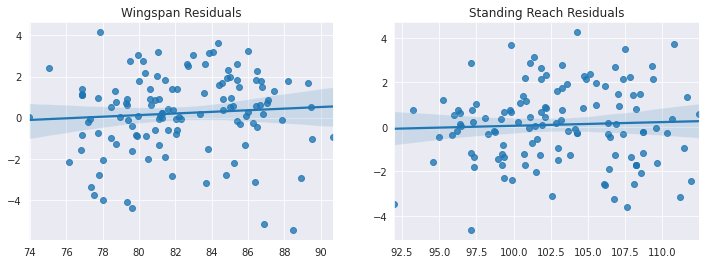

In [811]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.set_style('darkgrid')
y_test[:,0].numpy()-predictions_mten[:,0]
sns.regplot(ax=ax[0],x=predictions_mten[:,0],y=(y_test[:,0].numpy()-predictions_mten[:,0]))
ax[0].set(title='Wingspan Residuals')
sns.regplot(ax=ax[1],x=predictions_mten[:,1],y=(y_test[:,1].numpy()-predictions_mten[:,1]))
s=ax[1].set(title='Standing Reach Residuals')

### Predictions for Players That Skipped Combine

Here's we start to have some fun looking at predictions for players that never officially were measured at the Combine. In general, the model does a good job based on what these players have measured at earlier events in their pre-professional careers. But there are obvious discrepancies in some of them. For example, Obi Toppin, Marvin Bagley, and Zion Williamson are predicted to have substantially longer wingspans than is believed (in Zion and Bagley case we know they have shorter wingspans from earlier measurements). This is interesting, and perhaps, not surprising given the features we put in the model. It also points in each case how adding athletic measurements or at least an estimation could interact with the other features and improve the predictions. If we put in that Zion has a 44" vert, then it "explains away" some of his length.

In [829]:
predictions_skipped = mten.predict(x_skipped_norm)
ft, inches = np.divmod(predictions_skipped,12)
for idx, name, height, weight in skipped_combine[['name','height','weight']].itertuples():
    ht_ft, ht_in = np.divmod(height,12)
    print(f"{name} ({ht_ft}'{ht_in}\" ht {weight} wt) => {int(ft[idx][0]):0}'{inches[idx][0]:0.1f}\" ws {int(ft[idx][1]):0}'{inches[idx][1]:0.1f}\" sr")

obi-toppin (6'8" ht 220 wt) => 7'2.1" ws 8'11.4" sr
devin-vassell (6'5" ht 180 wt) => 6'9.3" ws 8'6.3" sr
aaron-nesmith (6'5" ht 213 wt) => 6'9.5" ws 8'6.1" sr
tyrese-haliburton (6'4" ht 175 wt) => 6'7.7" ws 8'4.5" sr
saddiq-bey (6'7" ht 216 wt) => 6'10.6" ws 8'8.2" sr
tyrese-maxey (6'2" ht 200 wt) => 6'6.9" ws 8'2.4" sr
onyeka-okongwu (6'8" ht 245 wt) => 7'2.8" ws 9'0.1" sr
patrick-williams (6'7" ht 225 wt) => 7'0.3" ws 8'9.4" sr
cole-anthony (6'2" ht 190 wt) => 6'6.6" ws 8'2.3" sr
anthony-edwards (6'3" ht 225 wt) => 6'8.8" ws 8'4.3" sr
deandre-hunter (6'7" ht 222 wt) => 6'11.1" ws 8'8.5" sr
chuma-okeke (6'6" ht 233 wt) => 6'11.9" ws 8'8.7" sr
ja-morant (6'2" ht 170 wt) => 6'6.7" ws 8'2.6" sr
rj-barrett (6'6" ht 208 wt) => 6'10.2" ws 8'7.4" sr
zion-williamson (6'6" ht 272 wt) => 7'2.2" ws 8'10.1" sr
mikal-bridges (6'7" ht 200 wt) => 6'10.9" ws 8'8.5" sr
marvin-bagley-iii (6'10" ht 234 wt) => 7'3.2" ws 9'1.6" sr
deandre-ayton (6'11" ht 261 wt) => 7'5.0" ws 9'3.5" sr


### Potential 2021 Draftees

Let's do the same exercise for some of the potential (probable) 2021 NBA entrants. 

In [828]:
predictions_prospects = mten.predict(x_prospects_norm)
ft, inches = np.divmod(predictions_prospects,12)
for idx, name, height, weight in prospects[['name','height','weight']].itertuples():
    ht_ft, ht_in = np.divmod(height,12)
    print(f"{name} ({ht_ft}'{ht_in}\" ht {weight} wt) => {int(ft[idx][0]):0}'{inches[idx][0]:0.1f}\" ws {int(ft[idx][1]):0}'{inches[idx][1]:0.1f}\" sr")

evan-mobley (6'11" ht 210 wt) => 7'3.4" ws 9'2.5" sr
greg-brown (6'8" ht 205 wt) => 7'0.4" ws 8'10.5" sr
brandon-boston-jr (6'6" ht 185 wt) => 6'9.0" ws 8'6.6" sr
jaden-springer (6'3" ht 204 wt) => 6'7.9" ws 8'3.8" sr
jalen-suggs (6'3" ht 205 wt) => 6'8.0" ws 8'3.8" sr
cade-cunningham (6'7" ht 220 wt) => 6'11.0" ws 8'8.4" sr
josh-christopher (6'4" ht 215 wt) => 6'9.1" ws 8'5.2" sr
isaiah-jackson (6'9" ht 206 wt) => 7'2.8" ws 9'1.0" sr
moses-moody (6'5" ht 205 wt) => 6'9.2" ws 8'6.1" sr
sharife-cooper (6'0" ht 180 wt) => 6'4.9" ws 7'11.9" sr
cameron-thomas (6'3" ht 210 wt) => 6'7.6" ws 8'3.4" sr
dayron-sharpe (6'10" ht 265 wt) => 7'3.4" ws 9'1.7" sr
justin-powell (6'5" ht 205 wt) => 6'8.7" ws 8'5.7" sr
scottie-barnes (6'8" ht 227 wt) => 6'11.9" ws 8'9.6" sr
ziaire-williams (6'7" ht 185 wt) => 6'10.0" ws 8'7.9" sr
marcus-bagley (6'7" ht 215 wt) => 6'10.7" ws 8'8.4" sr
bennedict-mathurin (6'6" ht 195 wt) => 6'9.6" ws 8'7.1" sr
efe-abogidi (6'9" ht 225 wt) => 7'1.8" ws 8'12.0" sr


## Bayesian Multivariate Model

This is the part where you can tune out or stop reading if you only came here for some predictions and dataset. The original intent of this article was to explore a Bayesian multivariate model for these measurements. It's important to understand what is meant by `multivariate` here. People often confuse or use interchangeably `multivariate`, `multilinear`, and `multiple` in a regression context, but specifically, `multivariate linear regression` assumes that there are multiple outputs (dependent variables) that are correlated with each other. And clearly (as can be seen in the pair plots above) wingspan and standing reach are highly correlated. So it made sense to me to treat it this way and learn something new in Pyro as well as explored below.

As shown in the code below $\beta$ encodes the standard linear regression coefficients and $B0$ represents the intercepts. The way we model the correlation between the outputs wingspan and standing reach is to use a `MultivariateNormal` distribution with a covariance that is inferred by the data. Essentially the most important random variable here is `L` which is the `LKJCorrCholesky` prior on the covariance matrix. 

In [830]:
def model(x, y=None):
    β = pyro.sample("β", dist.Normal(torch.zeros(x.shape[1],2),torch.ones(x.shape[1],2)).to_event(2))
    B0 = pyro.sample("B0", dist.Normal(torch.zeros(2,),torch.ones(2,)))
    μ = torch.matmul(x,β) +  B0
    θ = pyro.sample("θ", dist.HalfNormal(torch.ones(2)))
    η = pyro.sample("η", dist.HalfNormal(1.))
    L = pyro.sample("L", dist.LKJCorrCholesky(2, η))
    L_Ω = torch.mm(torch.diag(θ.sqrt()), L)
    with pyro.plate("data", x.shape[0]):
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=μ, scale_tril=L_Ω), obs=y)

With the model setup we can use the variational inference or MCMC modules in Pyro. I tried both and found better results with MCMC, although it is more time consuming.

In [832]:
from pyro.infer import NUTS, MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 1000)
mcmc.run(torch.tensor(x_train_norm), torch.tensor(y_train))

Sample: 100%|██████████| 2000/2000 [08:35,  3.88it/s, step size=1.79e-01, acc. prob=0.933]


In [833]:
mcmc.summary()
# 'HEIGHT_WO_SHOES'=0,'WEIGHT'=1,'stl'=2,'blk'=3,'orb'=4,'drb'=5,'dunks'=6


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    β[0,0]      1.80      0.13      1.79      1.59      2.01    820.24      1.00
    β[0,1]      3.30      0.13      3.31      3.09      3.51    707.67      1.00
    β[1,0]      0.82      0.12      0.82      0.62      1.02    791.74      1.00
    β[1,1]      0.32      0.13      0.32      0.11      0.52    718.98      1.00
    β[2,0]     -0.00      0.08     -0.00     -0.13      0.14    856.86      1.00
    β[2,1]     -0.09      0.08     -0.09     -0.21      0.05    774.38      1.00
    β[3,0]      0.60      0.11      0.59      0.43      0.79    677.61      1.00
    β[3,1]      0.45      0.11      0.45      0.24      0.60    718.04      1.00
    β[4,0]      0.09      0.14      0.10     -0.11      0.33    496.03      1.00
    β[4,1]      0.33      0.13      0.33      0.10      0.53    376.95      1.00
    β[5,0]      0.12      0.11      0.12     -0.03      0.31    642.58      1.00
    β[5,1]      0.15      0

You might be interested to look at the coefficients above in terms of inference. The variables that have 0 in the 90%-posterior density are not so important. For example, this would includes $\beta[2,0]$ and $\beta[2,1]$, which are the coefficients for steals. That actually makes some sense because the relationship between steal rate and height or position is fairly complex. In fact if you look at the pair plot above steal rate is the only metric that seems negatively correlated with the other features. All else being equal, one would expect higher steal rate to reflect longer wingspan (and by correlation standing reach), but the linear model doesn't show this, perhaps because of the high level of feature correlation. I actually tried adding interactions to the model, but didn't find any increase in prediction accuracy. Will keep thinking about this...

Below we look at the loss in the test set and as you can see it's disappointingly lower than the ML models in the first part. Oh well!

In [837]:
samples_mcmc = mcmc.get_samples(1000)
skipped_mcmc = Predictive(model, samples_mcmc).forward(torch.tensor(x_skipped_norm))
test_mcmc = Predictive(model, samples_mcmc).forward(torch.tensor(x_test_norm))
prospects_mcmc = Predictive(model, samples_mcmc).forward(torch.tensor(x_prospects_norm))

In [842]:
loss = (test_mcmc['obs']-torch.tensor(y_test)).detach().square().sum(axis=2).mean(axis=0).mean(axis=0).sqrt()
loss

tensor(4.0431)

However, it's still fun to look at the distributions. The first plot is the joint distribution between the WS and SR residuals. The second plot is the joint distribution of the predictions and the third plot is the joint of the actual test data.

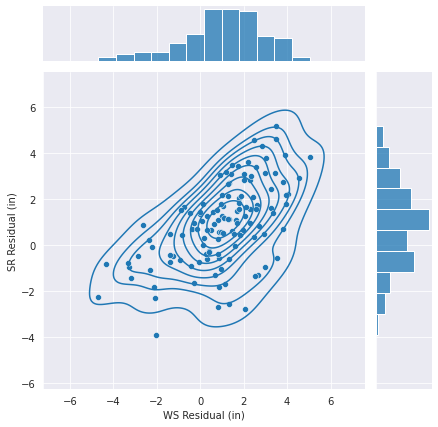

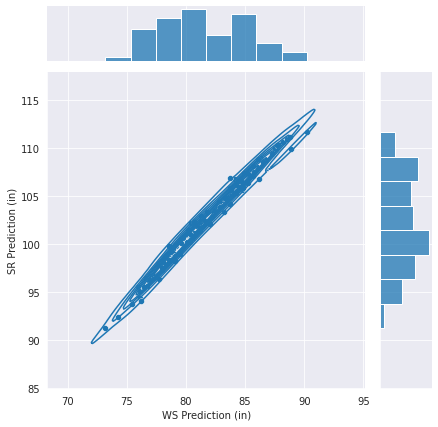

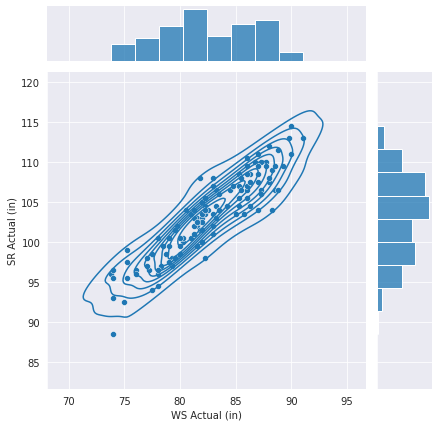

In [857]:
a = sns.jointplot(x=y_test[:,0]-test_mcmc['obs'][:,:,0].mean(axis=0).detach().numpy(),y=y_test[:,1]-test_mcmc['obs'][:,:,1].mean(axis=0).detach().numpy()).plot_joint(sns.kdeplot)
a.fig.tight_layout()
a.set_axis_labels(xlabel='WS Residual (in)', ylabel='SR Residual (in)')
a.fig.subplots_adjust(top=0.95) 
a = sns.jointplot(x=test_mcmc['obs'][:,:,0].mean(axis=0).detach().numpy(),y=test_mcmc['obs'][:,:,1].mean(axis=0).detach().numpy()).plot_joint(sns.kdeplot)
a.fig.tight_layout()
a.set_axis_labels(xlabel='WS Prediction (in)', ylabel='SR Prediction (in)')
a.fig.subplots_adjust(top=0.95) 
a = sns.jointplot(x=y_test[:,0],y=y_test[:,1]).plot_joint(sns.kdeplot)
a.fig.tight_layout()
a.set_axis_labels(xlabel='WS Actual (in)', ylabel='SR Actual (in)')
a.fig.subplots_adjust(top=0.95)

The following are the residual plots as a function of wingspan and standing reach as before.

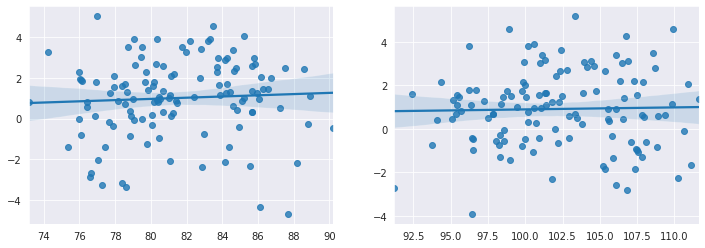

In [859]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.set_style('darkgrid')
sns.regplot(ax=ax[0],x=test_mcmc['obs'][:,:,0].mean(axis=0).detach().numpy(),y=(y_test[:,0].numpy()-test_mcmc['obs'][:,:,0].mean(axis=0).detach().numpy()))
g=sns.regplot(ax=ax[1],x=test_mcmc['obs'][:,:,1].mean(axis=0).detach().numpy(),y=(y_test[:,1].numpy()-test_mcmc['obs'][:,:,1].mean(axis=0).detach().numpy()))

By inspection the model predictions aren't obviously worse than the ML model earlier, but we know the test loss was greater.

In [861]:
ft, inches = np.divmod(skipped_mcmc['obs'].detach().mean(axis=0).numpy(),12)
for idx, name, height, weight in skipped_combine[['name','height','weight']].itertuples():
    ht_ft, ht_in = np.divmod(height,12)
    print(f"{name} ({ht_ft}'{ht_in}\" ht {weight} wt) => {int(ft[idx][0]):0}'{inches[idx][0]:0.1f}\" ws {int(ft[idx][1]):0}'{inches[idx][1]:0.1f}\" sr")

obi-toppin (6'8" ht 220 wt) => 7'1.6" ws 8'10.6" sr
devin-vassell (6'5" ht 180 wt) => 6'8.4" ws 8'5.6" sr
aaron-nesmith (6'5" ht 213 wt) => 6'8.7" ws 8'5.2" sr
tyrese-haliburton (6'4" ht 175 wt) => 6'6.7" ws 8'3.5" sr
saddiq-bey (6'7" ht 216 wt) => 6'9.8" ws 8'7.3" sr
tyrese-maxey (6'2" ht 200 wt) => 6'6.2" ws 8'1.7" sr
onyeka-okongwu (6'8" ht 245 wt) => 7'2.1" ws 8'11.3" sr
patrick-williams (6'7" ht 225 wt) => 6'11.4" ws 8'8.4" sr
cole-anthony (6'2" ht 190 wt) => 6'5.9" ws 8'1.4" sr
anthony-edwards (6'3" ht 225 wt) => 6'8.1" ws 8'3.3" sr
deandre-hunter (6'7" ht 222 wt) => 6'10.2" ws 8'7.7" sr
chuma-okeke (6'6" ht 233 wt) => 6'11.2" ws 8'7.9" sr
ja-morant (6'2" ht 170 wt) => 6'5.7" ws 8'1.7" sr
rj-barrett (6'6" ht 208 wt) => 6'9.3" ws 8'6.5" sr
zion-williamson (6'6" ht 272 wt) => 7'1.7" ws 8'9.3" sr
mikal-bridges (6'7" ht 200 wt) => 6'9.9" ws 8'7.6" sr
marvin-bagley-iii (6'10" ht 234 wt) => 7'2.5" ws 9'1.0" sr
deandre-ayton (6'11" ht 261 wt) => 7'4.3" ws 9'2.7" sr


In [862]:
ft, inches = np.divmod(prospects_mcmc['obs'].detach().mean(axis=0).numpy(),12)
for idx, name, height, weight in prospects[['name','height','weight']].itertuples():
    ht_ft, ht_in = np.divmod(height,12)
    print(f"{name} ({ht_ft}'{ht_in}\" ht {weight} wt) => {int(ft[idx][0]):0}'{inches[idx][0]:0.1f}\" ws {int(ft[idx][1]):0}'{inches[idx][1]:0.1f}\" sr")

evan-mobley (6'11" ht 210 wt) => 7'2.6" ws 9'1.7" sr
greg-brown (6'8" ht 205 wt) => 6'11.6" ws 8'9.7" sr
brandon-boston-jr (6'6" ht 185 wt) => 6'7.9" ws 8'5.9" sr
jaden-springer (6'3" ht 204 wt) => 6'7.1" ws 8'3.1" sr
jalen-suggs (6'3" ht 205 wt) => 6'7.2" ws 8'2.9" sr
cade-cunningham (6'7" ht 220 wt) => 6'10.2" ws 8'7.5" sr
josh-christopher (6'4" ht 215 wt) => 6'8.3" ws 8'4.3" sr
isaiah-jackson (6'9" ht 206 wt) => 7'2.0" ws 9'0.3" sr
moses-moody (6'5" ht 205 wt) => 6'8.4" ws 8'5.3" sr
sharife-cooper (6'0" ht 180 wt) => 6'4.0" ws 7'11.0" sr
cameron-thomas (6'3" ht 210 wt) => 6'6.8" ws 8'2.5" sr
dayron-sharpe (6'10" ht 265 wt) => 7'2.5" ws 9'0.9" sr
justin-powell (6'5" ht 205 wt) => 6'7.6" ws 8'4.7" sr
scottie-barnes (6'8" ht 227 wt) => 6'11.0" ws 8'8.7" sr
ziaire-williams (6'7" ht 185 wt) => 6'9.0" ws 8'7.1" sr
marcus-bagley (6'7" ht 215 wt) => 6'9.8" ws 8'7.5" sr
bennedict-mathurin (6'6" ht 195 wt) => 6'8.8" ws 8'6.3" sr
efe-abogidi (6'9" ht 225 wt) => 7'1.0" ws 8'11.3" sr


With the Bayesian model we can look at the joint distribution for an individual player. Below is the joint for Obi Toppin. 

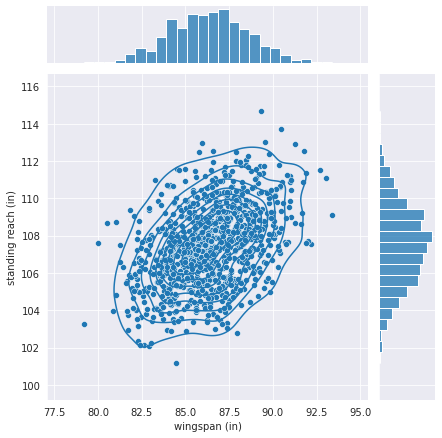

In [864]:
g = sns.jointplot(x=skipped_samples['obs'][:,0,0].detach().numpy(),y=skipped_samples['obs'][:,0,1].detach().numpy()).plot_joint(sns.kdeplot)
g.set_axis_labels(xlabel='wingspan (in)',ylabel='standing reach (in)')

If you did make it this far, kudos! Now go and play around with the notebook and data and if you come up with something better, please publish it!

## If you enjoyed this project, please leave a Github Star!